In [1]:
from fastai.vision.all import *
import pylab as plt

Define function to plot the output of any given quadratic function

In [2]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max,steps=20)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x, f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

Define quadratic function $3x^2 + 2x + 1$

In [3]:
def quad(x): return 3 * x**2 + 2 * x + 1

Plot our quadratic function

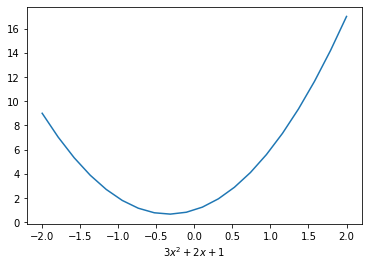

In [4]:
plot_function(quad, '$3x^2 + 2x + 1$')

Define a generalized quadratic function

In [5]:
def quad(a, b, c, x): return a * x**2 + b * x + c

Let's also define a factory function that can create any desired quadratic. The `partial` function is used to 'fix' the values of a, b, and coefficients

In [6]:
from functools import partial
def make_quad(a, b, c) : return partial(quad, a, b, c)

Use the factory to re-create our quadratic

In [7]:
f = make_quad(3, 2, 1)

Let's generate some random normally distributed data. Then we will use our quadratic functiomn to 'fit' this data

In [8]:
from numpy.random import normal, seed, uniform
def noise(x, scale) : return normal(scale = scale, size = x.shape)
def add_noise(x, mult, add): return x + (1 + noise(x, mult)) + noise(x, add)

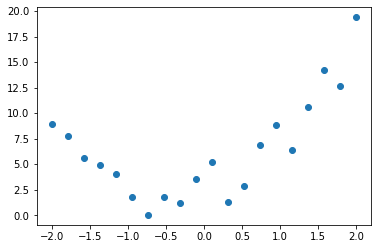

In [9]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x, y)

In order to see how well our quadratic function fits the data and to try out different variations of the quad coefficients, we will create an interactive function that will plot our random data and the output of the quad function on same plot. We can then vary the quad coefficients to try better fit with the data.

In [10]:
from ipywidgets import interact

In [11]:
@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    plot_function(make_quad(a, b, c))
    plt.scatter(x, y)

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

That was fun but judging whether a particular combination of coefficients is better than previous combinations was very subjective. Let's correct that by creating a `loss` function. The function will take predictions and actual observations and calculate the Mean Square Error (MSE)

In [12]:
def mse(pred, actual) : return ((pred - actual) ** 2).mean()

Let's modify our interactive function to plot our data and output of the quad function on same plot and also add the MSE to the plot so we can easily tell whether the new coefficient setting is improved and degraded the model

In [13]:
@interact(a = 1.5, b = 1.5, c = 1.5)
def plot_quad(a, b, c):
    f = make_quad(a, b, c)
    loss = mse(f(x), y)
    title = "MSE: " + str(loss)
    plot_function(f, title=f'MSE: {loss:.2f}')
    plt.scatter(x, y)

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Cool. That was better but it would be great if finding the best combination of coefficients - i.e. smallest MSE - could be automated. After that that is what we'd like our model to do.

Let's wrap the creating of the loss function and calculation of the MSE into a single function `quad_mse`

In [14]:
def quad_mse(params):
    f = make_quad(*params)
    return mse(f(x), y)

For sanity check, let's compute the MSE using our default coefficient settings '[1.5, 1.5, 1.5]'.

In [16]:
quad_mse([1.5, 1.5, 1.5])

tensor(13.2768, dtype=torch.float64)

Let's compute MSE at another coefficient settings. This is much better!

In [17]:
quad_mse([3.0, 1.5, 1.5])

tensor(3.2585, dtype=torch.float64)

Once more. Oops, loss increased this time!

In [18]:
quad_mse([3.5, 1.5, 1.5])

tensor(3.8152, dtype=torch.float64)

We can keep doing this and eventually (hopefully) we'd arrive at an acceptable loss which would give us the optimal coefficients for fitting our data. This is roughly how a deep neural network does its learning!

You may have noticed that sometimes a coefficient value had to be increased and sometimes decreased to get a better (lower) loss. We didn't really know ahead of time whether it was good idea to increase or decrease a particular coefficient. We made the change, observed the resulting MSE, and then we knew whether or not the change improved the model.

Wouldn't it be nice it we knew whether to increase or decrease a particular coefficient **before** making that change? That's where the gradient comes in!

Let's create a tensor to calculate the quadratic MSE

In [20]:
a_tensor = tensor([1.5, 1.5, 1.5])
a_tensor

tensor([1.5000, 1.5000, 1.5000])

Then we tell Pytorch that we'd like to compute gradient at that tensor. Note, Pytorch has flagged (requires_grad) that this tensor requires gradient whenever it's used in calculations

In [21]:
a_tensor.requires_grad_()
a_tensor

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

Let's compute the quadratic MSE using our tensor. Note, in the output of the calculation Pytorch informs us that it knows how to calculate the gradients

In [22]:
loss = quad_mse(a_tensor)
loss

tensor(13.2768, dtype=torch.float64, grad_fn=<MeanBackward0>)

Let's ask Pytorch to go ahead and calculate the gradients. Nothing seems to to have happened but... 

In [23]:
loss.backward()

Pytorch has updated the tensor with gradients for each coefficient!

Let's take a look at the gradients. Gradients are telling us that:
- loss will go down by a lot if we increase the first parameter **a**
- loss will go down somewhat if we increase the second parameter **b**
- loss will go down if we increase the tird parameter **c**

And there we have all the basic machinery use our quadratic function (model) to predict (y) from the input (x), calculate the gradient for model parameters, modify the model parameters, and repeat until the loss no longer decreases.

In [24]:
a_tensor.grad

tensor([-12.5230,  -2.2051,  -5.3897])